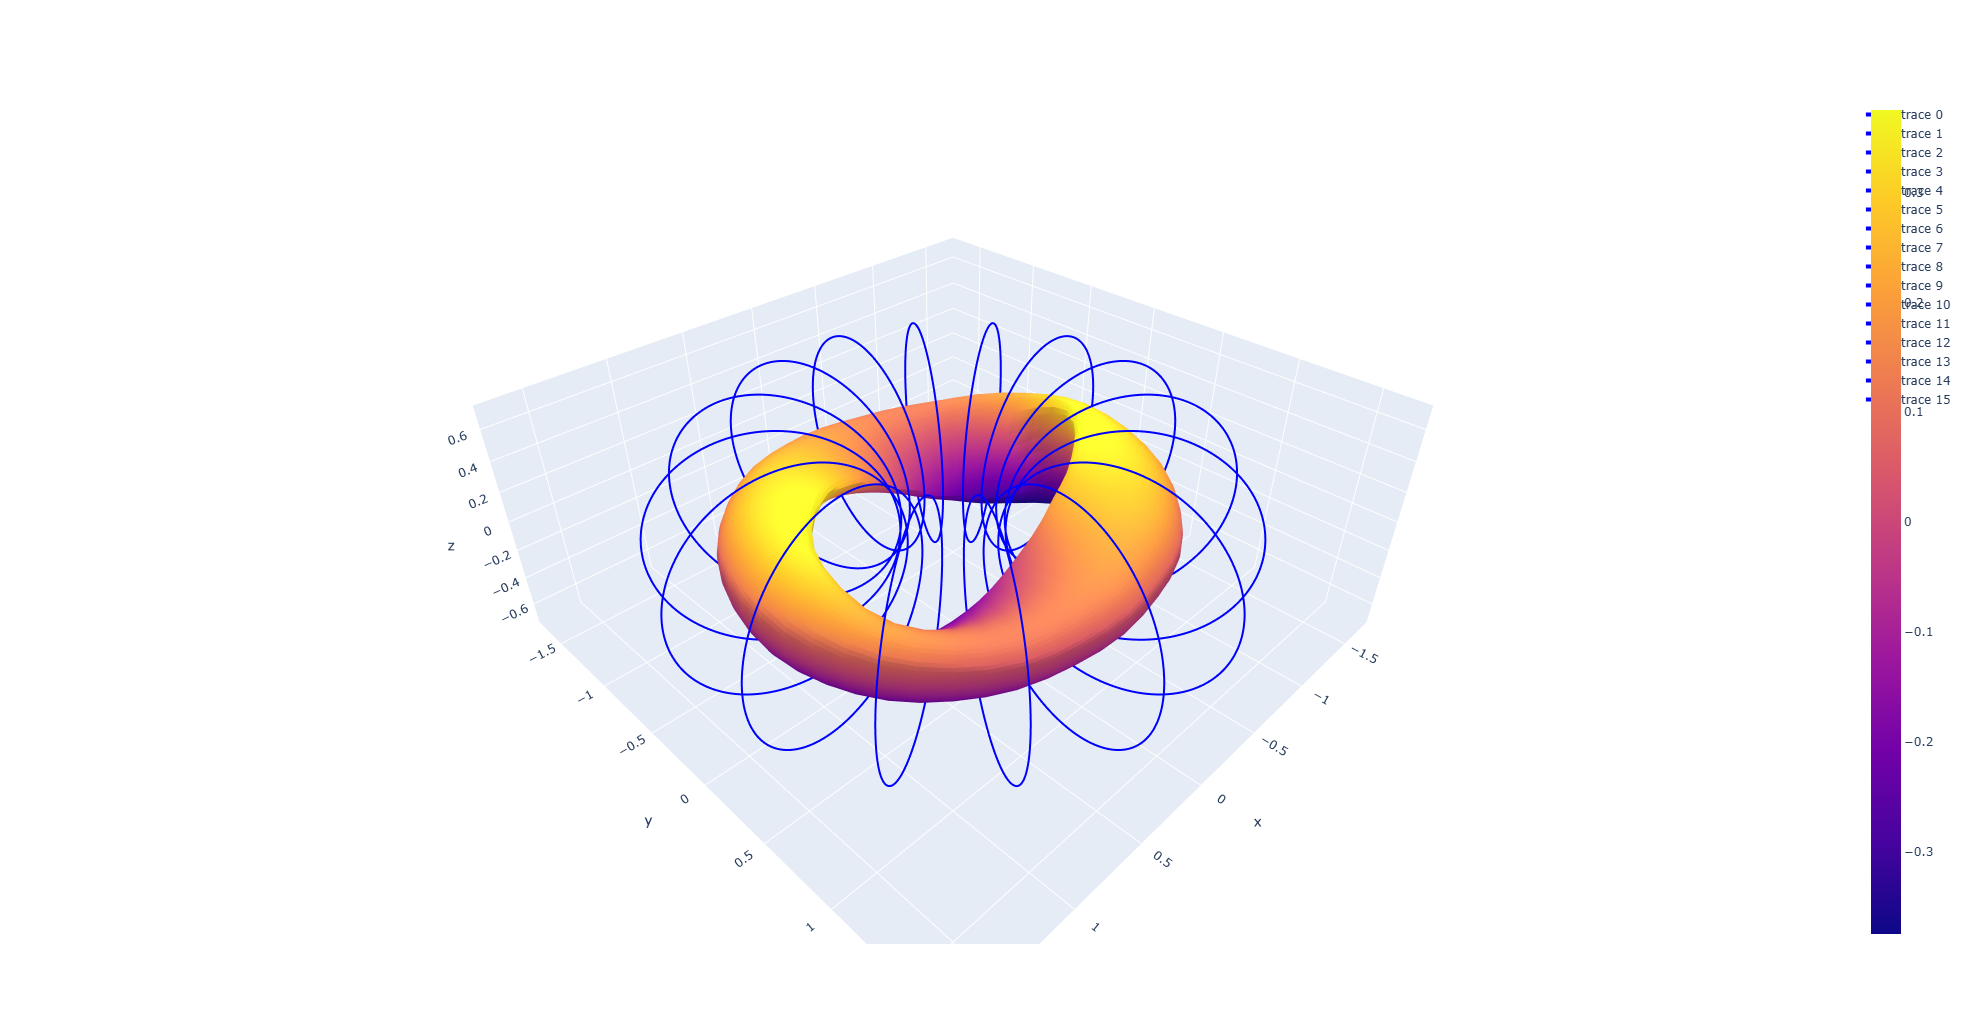

In [15]:
""" #%%
from simsopt.geo import CurveXYZFourier

curve = CurveXYZFourier(300,1)
curve.set_dofs([0,0,0,0,1,0,0,0,1])
curve.plot() """

import matplotlib.pyplot as plt
import numpy as np
from simsopt._core import load
from simsopt.geo import plot, MeanSquaredCurvature, CurveSurfaceDistance, CurveCurveDistance, LpCurveCurvature
from simsopt.geo import SurfaceRZFourier, create_equally_spaced_curves, \
    CurveLength, curves_to_vtk, CurveCWSFourier, ArclengthVariation
from simsopt.field import Current, coils_via_symmetries, BiotSavart
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from scipy.optimize import minimize

res = load(f'serial0021326.json')

MAXITER = 600
quadpoints = 300
USE_PRESIM = False
USE_CWS = True

major_R = 1
minor_r = 0.6 #parameter search
ncoils = 4
order = 3
nfp_coils = 1
current_0  = 1
current_mult = 1e2
FIX_ONE_CURRENT = False



nphi = 48
ntheta = 48
s = SurfaceRZFourier.from_vmec_input('input', range="full torus", nphi=nphi, ntheta=ntheta)

##creating coils and currents:
#if USE_PRESIM:
#    coils_presim = res[1]
#    surface = res[0][-1]
#    base_curves = [x.curve for x in coils_presim]
#    base_currents = [x.current for x in coils_presim]
#    base_currents[0].fix_all()
#else:
#    base_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=1, R1=0.6, order=order)
#    base_currents = [Current(current_0) for i in range(ncoils)]
#    if FIX_ONE_CURRENT:
#        base_currents[0].fix_all()

if USE_CWS:
    theta_linspace = np.linspace(0, 1, ntheta, endpoint=True)
    phi_linspace = np.linspace(0, 1, nphi, endpoint=True)
    # currently don't know what this does, most likely only extension away from plasma
    # this could be necessary if the CWS is more complicated and is generated from a stage I 
    # ext_via_normal_factor = 0.2565
    #ext_via_normal_factor = 0.1482   
    #cws.extend_via_normal(ext_via_normal_factor)
    #0.25216216216216214
    # CREATE COIL WINDING SURFACE SURFACE
    cws = SurfaceRZFourier(nfp=nfp_coils,stellsym=True)
    cws.set_rc(0,0,major_R)
    cws.set_rc(major_R,0,minor_r+0.1)
    cws.set_zs(major_R,0,minor_r+0.1)

    # CREATE CURVES + COILS     
    base_curves = []
    for i in range(ncoils):
        curve_cws = CurveCWSFourier(
            mpol=cws.mpol,
            ntor=cws.ntor,
            idofs=cws.x,
            quadpoints=quadpoints,
            order=order,
            nfp=nfp_coils,
            stellsym=cws.stellsym,
        )
        angle = (i + 0.5)*(2 * np.pi)/((2) * s.nfp * ncoils)
        curve_dofs = np.zeros(len(curve_cws.get_dofs()),)
        curve_dofs[0] = 1
        curve_dofs[2*order+2] = 0
        curve_dofs[2*order+3] = angle
        curve_cws.set_dofs(curve_dofs)
        curve_cws.fix(0)
        curve_cws.fix(2*order+2)
        base_curves.append(curve_cws)
    base_currents = [Current(current_0)*current_mult for i in range(ncoils)]
    if FIX_ONE_CURRENT:
        base_currents[0].fix_all()
   


coils = coils_via_symmetries(base_curves, base_currents, nfp_coils*2, True)
curves = [c.curve for c in coils]

fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()


In [16]:
##calculating magnetic field from coils:

bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))

#curves = [c.curve for c in coils]
#curves_to_vtk(curves, "/curves_init", close=True)
#curves_to_vtk(base_curves, "/base_curves_init", close=True)
#pointData = {"B.n": np.sum(bs.B().reshape((int(nphi*2*s.nfp), ntheta, 3)) * s_full.unitnormal(), axis=2)[:, :, None]}
#s.to_vtk("/surf_init", extra_data=pointData)
#cws.to_vtk("/cws_init")


FLUX_WEIGHT = 100

##setting up parameters for penalty function:
# Threshold and weight for the maximum length of each individual coil:
#LENGTH_THRESHOLD = 20
#LENGTH_WEIGHT = 1e-8

LENGTH_THRESHOLD = 20  
LENGTH_WEIGHT = 1e-8


# Threshold and weight for the coil-to-coil distance penalty in the objective function:
#CC_THRESHOLD = 0.1
#CC_WEIGHT = 100

CC_THRESHOLD = 0.2
CC_WEIGHT = 100


# Threshold and weight for the curvature penalty in the objective function:
#CURVATURE_THRESHOLD = 60
#CURVATURE_WEIGHT = 1e-5

CURVATURE_THRESHOLD = 20
CURVATURE_WEIGHT = 1e-2


# Threshold and weight for the mean squared curvature penalty in the objective function:
#MSC_THRESHOLD = 60
#MSC_WEIGHT = 1e-9
#ARCLENGTH_WEIGHT = 3e-8
#LENGTH_CON_WEIGHT = 0.1

MSC_THRESHOLD = 60
MSC_WEIGHT = 1e-9
ARCLENGTH_WEIGHT = 3e-8
LENGTH_CON_WEIGHT = 0.1

Jf = FLUX_WEIGHT * SquaredFlux(s, bs, definition="local")
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=len(curves))
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for i, c in enumerate(base_curves)]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
Jals = [ArclengthVariation(c) for c in base_curves]
J_LENGTH = LENGTH_WEIGHT * sum(Jls)
J_CC = CC_WEIGHT * Jccdist
J_CURVATURE = CURVATURE_WEIGHT * sum(Jcs)
J_MSC = MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD, f="max") for i, J in enumerate(Jmscs))
J_ALS = ARCLENGTH_WEIGHT * sum(Jals)
J_LENGTH_PENALTY = LENGTH_CON_WEIGHT * sum([QuadraticPenalty(Jls[i], LENGTH_THRESHOLD, f="max") for i in range(len(base_curves))])
JF = Jf + J_CC + J_LENGTH_PENALTY + J_CURVATURE + J_ALS + J_MSC + J_LENGTH


B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)

print('Initial max|B dot n|:', np.max(np.abs(B_dot_n)))



def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    outstr = f"J={J:.3e}, Jf={jf:.3e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}"
    print(outstr)
    return J, grad
    

print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
for eps in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    print("err", (J1-J2)/(2*eps) - dJh)

print("""
################################################################################
### Run the optimisation #######################################################
################################################################################
""")

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
B_dot_n_max = np.max(np.abs(B_dot_n)).copy()

total_curve_length_start = sum(func.J() for func in Jls).copy()


res = minimize(fun, dofs, jac=True, method='L-BFGS-B',
               options={'maxiter': MAXITER, 'maxcor': 500, 'iprint': 5}, tol=1e-15)

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
print('starting max|B dot n|:', B_dot_n_max)
print('Final max|B dot n|:', np.max(np.abs(B_dot_n)))
total_curve_length = sum(func.J() for func in Jls)
print("starting Sum of lengths of base curves:", total_curve_length_start)
print("Sum of lengths of base curves:", total_curve_length)

Initial max|B dot n|: 0.0003272136258599122

################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=2.633e+01, Jf=2.536e+01, ⟨B·n⟩=6.1e-05, Len=sum([4.4, 4.4, 4.4, 4.4])=17.6, ϰ=[1.4, 1.4, 1.4, 1.4], ∫ϰ²/L=[2.0, 2.0, 2.0, 2.0], C-C-Sep=0.12
J=2.633e+01, Jf=2.535e+01, ⟨B·n⟩=6.1e-05, Len=sum([4.4, 4.4, 4.4, 4.4])=17.6, ϰ=[1.4, 1.4, 1.4, 1.4], ∫ϰ²/L=[2.0, 2.0, 2.0, 2.0], C-C-Sep=0.12
J=2.633e+01, Jf=2.536e+01, ⟨B·n⟩=6.1e-05, Len=sum([4.4, 4.4, 4.4, 4.4])=17.6, ϰ=[1.4, 1.4, 1.4, 1.4], ∫ϰ²/L=[2.0, 2.0, 2.0, 2.0], C-C-Sep=0.12
err -6.869272878695654e-05
J=2.633e+01, Jf=2.536e+01, ⟨B·n⟩=6.1e-05, Len=sum([4.4, 4.4, 4.4, 4.4])=17.6, ϰ=[1.4, 1.4, 1.4, 1.4], ∫ϰ²/L=[2.0, 2.0, 2.0, 2.0], C-C-Sep=0.12
J=2.633e+01, Jf=2.536e+01, ⟨B·n⟩=6.1e-05, Len=sum([4.4, 4.4, 4.4, 4.4])=17.6, ϰ=[1.4, 1.4, 1.4, 1.4], ∫ϰ²/L=[2.0

 This problem is unconstrained.


J=2.708e+01, Jf=2.183e+01, ⟨B·n⟩=5.9e-05, Len=sum([5.0, 4.8, 5.0, 5.0])=19.9, ϰ=[4.6, 4.2, 3.2, 2.3], ∫ϰ²/L=[3.6, 3.2, 2.6, 2.1], C-C-Sep=0.05
J=1.628e+01, Jf=1.487e+01, ⟨B·n⟩=4.6e-05, Len=sum([4.6, 4.5, 4.5, 4.6])=18.2, ϰ=[2.6, 2.4, 2.0, 1.8], ∫ϰ²/L=[2.6, 2.4, 2.2, 2.1], C-C-Sep=0.09
J=1.391e+01, Jf=1.161e+01, ⟨B·n⟩=3.9e-05, Len=sum([4.8, 4.8, 4.7, 4.6])=18.9, ϰ=[3.6, 4.1, 2.6, 2.0], ∫ϰ²/L=[3.3, 3.5, 2.6, 2.1], C-C-Sep=0.06
J=1.304e+01, Jf=9.844e+00, ⟨B·n⟩=3.4e-05, Len=sum([5.0, 5.1, 4.9, 4.6])=19.7, ϰ=[4.9, 6.0, 4.6, 2.1], ∫ϰ²/L=[3.9, 4.0, 3.4, 2.2], C-C-Sep=0.06
J=1.253e+01, Jf=9.529e+00, ⟨B·n⟩=3.2e-05, Len=sum([5.1, 5.2, 4.9, 4.7])=19.9, ϰ=[5.5, 6.3, 5.1, 2.4], ∫ϰ²/L=[4.1, 4.1, 3.6, 2.4], C-C-Sep=0.06
J=1.231e+01, Jf=9.420e+00, ⟨B·n⟩=3.2e-05, Len=sum([5.1, 5.1, 5.0, 4.7])=19.9, ϰ=[5.7, 6.4, 5.3, 2.5], ∫ϰ²/L=[4.2, 4.1, 3.6, 2.4], C-C-Sep=0.06

At iterate    5    f=  1.23100D+01    |proj g|=  3.93552D+00
J=1.216e+01, Jf=9.071e+00, ⟨B·n⟩=3.1e-05, Len=sum([5.2, 5.2, 5.1, 4.7])=20.2, ϰ=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.263e+02, Jf=5.514e+01, ⟨B·n⟩=9.7e-05, Len=sum([14.3, 23.2, 8.6, 12.1])=58.2, ϰ=[168.6, 374.5, 287.7, 3913.6], ∫ϰ²/L=[37.2, 33.8, 59.7, 1478.4], C-C-Sep=0.00
J=1.079e+01, Jf=7.296e+00, ⟨B·n⟩=2.5e-05, Len=sum([5.8, 5.7, 5.4, 5.3])=22.2, ϰ=[26.7, 34.6, 19.0, 28.4], ∫ϰ²/L=[15.8, 14.3, 8.2, 14.5], C-C-Sep=0.06
J=1.079e+01, Jf=7.289e+00, ⟨B·n⟩=2.5e-05, Len=sum([5.8, 5.7, 5.4, 5.3])=22.2, ϰ=[26.0, 33.9, 18.9, 27.1], ∫ϰ²/L=[15.7, 14.1, 8.1, 14.3], C-C-Sep=0.06

At iterate   50    f=  1.07856D+01    |proj g|=  7.62073D-01
J=1.079e+01, Jf=7.283e+00, ⟨B·n⟩=2.5e-05, Len=sum([5.8, 5.8, 5.4, 5.3])=22.2, ϰ=[25.7, 33.2, 19.0, 26.3], ∫ϰ²/L=[15.6, 14.0, 8.2, 14.1], C-C-Sep=0.06
J=1.079e+01, Jf=7.263e+00, ⟨B·n⟩=2.5e-05, Len=sum([5.8, 5.8, 5.4, 5.3])=22.3, ϰ=[24.5, 31.8, 19.5, 23.6], ∫ϰ²/L=[15.3, 13.6, 8.3, 13.5], C-C-Sep=0.06
J=1.078e+01, Jf=7.278e+00, ⟨B·n⟩=2.5e-05, Len=sum([5.8, 5.8, 5.4, 5.3])=22.2, ϰ=[25.4, 32.5, 19.2, 25.5], ∫ϰ²/L=[15.6, 13.9, 8.2, 13.9], C-C-Sep=0.06
J=1.080e+01, Jf=7.234e+00, 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [17]:
for current in base_currents:
    print(current.x)

[0.83841198]
[0.87830468]
[1.03716275]
[1.22113368]


In [18]:
fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()

In [ ]:
from simsopt.field import particles_to_vtk, compute_fieldlines
from simsopt.util import MpiPartition
from mpi4py import MPI
import time


mpi = MpiPartition(8)
comm = MPI.COMM_WORLD

def pprint(*args, **kwargs): print(*args, **kwargs) if comm.rank == 0 else 1

ntheta = 50
nphi = 42
nzeta = 4
nfieldlines = 8
#nfieldlines = 5

#tmax=3000
tmax=1000
tol=1e-15

def trace_fieldlines(bfield, R0, Z0):
    t1 = time.time()
    phis = [(i/nzeta)*(2*np.pi/s.nfp) for i in range(nzeta)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax, tol=tol, comm=comm, 
        phis=phis, stopping_criteria=[])
    t2 = time.time()
    pprint(f"Time for fieldline tracing={t2-t1:.3f}s. Num steps={sum([len(l) for l in fieldlines_tys])//12}", flush=True)
    return fieldlines_tys, fieldlines_phi_hits, phis

R0 = major_R
Z0 = minor_r


bs.save("biot_savart_opt.json")
fieldlines_tys, fieldlines_phi_hits, phis = trace_fieldlines(bs, R0, Z0)

pprint('Creating Poincare plot R, Z')
if comm.rank == 0:
    r = []
    z = []
    for izeta in range(len(phis)):
        r_2D = []
        z_2D = []
        for iradius in range(len(fieldlines_phi_hits)):
            lost = fieldlines_phi_hits[iradius][-1, 1] < 0
            data_this_phi = fieldlines_phi_hits[iradius][np.where(fieldlines_phi_hits[iradius][:, 1] == izeta)[0], :]
            if data_this_phi.size == 0:
                pprint(f'No Poincare data for iradius={iradius} and izeta={izeta}')
                continue
            r_2D.append(np.sqrt(data_this_phi[:, 2]**2+data_this_phi[:, 3]**2))
            z_2D.append(data_this_phi[:, 4])
        r.append(r_2D)
        z.append(z_2D)
    r = np.array(r, dtype=object)
    z = np.array(z, dtype=object)

    pprint('Plotting Poincare plot')
    nrowcol = ceil(sqrt(len(phis)))
    fig, axs = plt.subplots(nrowcol, nrowcol, figsize=(8, 8))
    for i in range(len(phis)):
        row = i//nrowcol
        col = i % nrowcol
        axs[row, col].set_title(f"$\\phi={phis[i]/np.pi:.2f}\\pi$", loc='right', y=0.0, fontsize=10)
        axs[row, col].set_xlabel("$R$", fontsize=14)
        axs[row, col].set_ylabel("$Z$", fontsize=14)
        axs[row, col].set_aspect('equal')
        axs[row, col].tick_params(direction="in")
        for j in range(nfieldlines):
            if j== 0 and i == 0:
                legend1 = 'Poincare'
                legend3 = 'CurveCWSFourier'
            else:
                legend1 = legend3 = '_nolegend_'
            axs[row, col].plot(R[i,j,:], Z[i,j,:], '-', linewidth=1.2, c='k', label = legend3)
            try: axs[row, col].scatter(r[i][j], z[i][j], marker='o', s=1.3, linewidths=1.3, c='b', label = legend1)
            except Exception as e: pprint(e, i, j)

    leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'output_cws_final_new.pdf'), bbox_inches = 'tight', pad_inches = 0)